In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import torch
import matplotlib.pyplot as plt
import os
os.environ['pRT_input_data_path'] = os.path.join('/home/mvasist/pRT/input_data_paper/input_data')

from petitRADTRANS.retrieval.rebin_give_width import rebin_give_width
from petitRADTRANS.retrieval.data import Data
from petitRADTRANS import Radtrans
from petitRADTRANS import nat_cst as nc

from lampe.data import H5Dataset

scratch = os.environ.get('SCRATCH', '')


In [2]:
pwd

'/home/mvasist/WISEJ1738/observation/MIRI'

## Rebinning to pRT wavelengths individually in each channel

iesfkdsnf

In [3]:
'''
Generate wavelengths of resolution 1000 in pRT and create and store in wavelengths folder. 
'''

'\nGenerate wavelengths of resolution 1000 in pRT and create and store in wavelengths folder. \n'

In [4]:
# path = Path('.') / 'MIRI/WISE1738_310723.txt'
path = Path('.') / 'WISE1738_reprocessed231123.txt'

spec= pd.DataFrame()
# spec = pd.read_csv(path, header=0, delimiter = ',')
spec = pd.read_csv(path, header=0, delimiter = ',', index_col = 0)

In [5]:
spec

,WAVELENGTH,FLUX,FLUX_ERROR,Band
0,4.90040,0.000198,0.000008,1A
1,4.90120,0.000271,0.000008,1A
2,4.90200,0.000269,0.000009,1A
3,4.90280,0.000366,0.000011,1A
4,4.90360,0.000527,0.000012,1A
...,...,...,...,...
9741,17.96875,0.000495,0.000016,3C
9742,17.97125,0.000589,0.000017,3C
9743,17.97375,0.000488,0.000018,3C
9744,17.97625,0.000490,0.000017,3C


## Rebinning old and whats used now

In [16]:
def wlenbins(w1):
    wlen_bins = np.zeros_like(w1)
    wlen_bins[:-1] = np.diff(w1)
    wlen_bins[-1] = wlen_bins[-2]
    return wlen_bins

def simulating_wavelengths(a,b):
    
    pRT_object = Radtrans(['CH4_hargreaves',
                        'H2O_Exomol',
#                         'CO2',
#                         'CO_all_iso_HITEMP',
#                         'H2S',
#                         'NH3',
#                         'PH3',
#                         'Na_allard',
#                         'K_allard',
#                         '15NH3' ,
                        'SO2'],
                     continuum_opacities=['H2-H2', 'H2-He'],
                     rayleigh_species=['He', 'H2'],
                     wlen_bords_micron=[a,b])  
    
    wlen = nc.c/pRT_object.freq/1e-4
    
    return wlen

def flux_rebin_old(spec, ch, c):
    
    a = np.arange(0, len(spec))
    ind = a[spec['Band'] == ch]
    print(ch)
    w , fl, fl_err = np.array(spec.iloc[ind, 0]), np.array(spec.iloc[ind,1]), np.array(spec.iloc[ind,2])
    mirisim_wlen_ch = simulating_wavelengths(w[0]+0.009, w[-1]-0.009)
    wlen_bins = wlenbins(mirisim_wlen_ch)
    flux_rebinned = torch.from_numpy(rebin_give_width(w, fl, mirisim_wlen_ch, wlen_bins))
    flux_rebinned_err = torch.from_numpy(rebin_give_width(w, fl_err, mirisim_wlen_ch, wlen_bins))
    print(len(flux_rebinned_err))
    return torch.stack((torch.from_numpy(mirisim_wlen_ch), flux_rebinned, flux_rebinned_err, torch.Tensor([c]*len(flux_rebinned))), dim=1)


In [17]:
channels = ['1A', '1B', '1C', '2A', '2B', '2C','3A', '3B', '3C']
    
flux_rebinned_o = torch.cat([ flux_rebin_old(spec, ch, c) for c, ch in enumerate(channels) ])
print(flux_rebinned_o.size())



1A
  Read line opacities of CH4_hargreaves...
 Done.
  Read line opacities of H2O_Exomol...
 Done.
  Read line opacities of SO2...
 Done.

  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
Done.

155
1B
  Read line opacities of CH4_hargreaves...
 Done.
  Read line opacities of H2O_Exomol...
 Done.
  Read line opacities of SO2...
 Done.

  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
Done.

156
1C
  Read line opacities of CH4_hargreaves...
 Done.
  Read line opacities of H2O_Exomol...
 Done.
  Read line opacities of SO2...
 Done.

  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
Done.

156
2A
  Read line opacities of CH4_hargreaves...
 Done.
  Read line opacities of H2O_Exomol...
 Done.
  Read line opacities of SO2...
 Done.

  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
Done.

153
2B
  Read line opacities of CH4_hargreaves...
 Done.
  Read line opacities of H2O_Exomol...
 Done.
  Read line opacities of SO2.

In [18]:
spec.iloc[:, 0]

0        4.90040
1        4.90120
2        4.90200
3        4.90280
4        4.90360
          ...   
9741    17.96875
9742    17.97125
9743    17.97375
9744    17.97625
9745    17.97875
Name: WAVELENGTH, Length: 9746, dtype: float64

In [ ]:
## Finding the rebinned wavelngths corresponding to the observed channel wavelengths

# path0 = Path('.') / 'WISE1738_reprocessed231123.txt'

# spec0= pd.DataFrame()
# spec0 = pd.read_csv(path0, header=0, delimiter = ',', index_col = 0)

# def simulating_wavelengths(a,b):
    
#     pRT_object = Radtrans(['CH4_hargreaves',
#                         'H2O_Exomol',
#                         'SO2'],
#                      continuum_opacities=['H2-H2', 'H2-He'],
#                      rayleigh_species=['He', 'H2'],
#                      wlen_bords_micron=[a,b])  
    
#     wlen = nc.c/pRT_object.freq/1e-4
    
#     return wlen

# channels = ['1A', '1B', '1C', '2A', '2B', '2C','3A', '3B', '3C']
# a = np.arange(0, len(spec0))

# wvls = {}


# for ch in channels:
#     wvls[ch] = {}
#     ind = a[spec0['Band'] == ch]
#     print(ch)
#     w , fl, fl_err = np.array(spec0.iloc[ind, 0]), np.array(spec0.iloc[ind,1]), np.array(spec0.iloc[ind,2])
#     print(w[0], w[-1])
#     wvls[ch]['obs'] = [w[0], w[-1]]
    
#     mirisim_wlen_ch = simulating_wavelengths(w[0]+0.009, w[-1]-0.009)
#     print(mirisim_wlen_ch[0], mirisim_wlen_ch[-1])
#     wvls[ch]['sim'] = [mirisim_wlen_ch[0], mirisim_wlen_ch[-1]]

## Rebinning acc to Paul's jupyter notebook

In [25]:
def simulating_wave(a,b):
    
    pRT_object = Radtrans(['CH4_hargreaves',
                        'H2O_Exomol',
#                         'CO2',
#                         'CO_all_iso_HITEMP',
#                         'H2S',
#                         'NH3',
#                         'PH3',
#                         'Na_allard',
#                         'K_allard',
#                         '15NH3' ,
                        'SO2'],
                     continuum_opacities=['H2-H2', 'H2-He'],
                     rayleigh_species=['He', 'H2'],
                     wlen_bords_micron=[a,b])  
    
#     wlen = nc.c/pRT_object.freq/1e-4

    bins_borders_take = nc.c/pRT_object.border_freqs/1e-4
    bins_borders_take_freq = pRT_object.border_freqs

    wavelens, widths = [], []
    wavelens = np.array((bins_borders_take_freq[1:]+bins_borders_take_freq[:-1])/2.)
    wavelens = nc.c/wavelens/1e-4
    widths = np.diff(bins_borders_take)

    index = (wavelens-widths/2. >= a-0.01) & \
          (wavelens+widths/2. <= b+0.01)

    wavelens = wavelens[index]
    widths = widths[index]
    
    return wavelens, widths




In [26]:
def flux_rebin_new(spec, ch):
    a = np.arange(0, len(spec))
    ind = a[spec['Band'] == ch]
    print(ch)
    w , fl, fl_err = np.array(spec.iloc[ind, 0]), np.array(spec.iloc[ind,1]), np.array(spec.iloc[ind,2])
    wavelens, widths = simulating_wave(w[0]+0.01, w[-1]-0.01)
#     xx = Data.convolve(w, fl, 1000)
#     xx_error = Data.convolve(w, fl_err, 1000)
    flux_rebinned = rebin_give_width(w,
                                fl,
                                wavelens,
                                widths)
    flux_rebinned_err = rebin_give_width(w,
                                fl_err,
                                wavelens,
                                widths)
    return torch.stack((torch.from_numpy(wavelens), torch.from_numpy(flux_rebinned), torch.from_numpy(flux_rebinned_err)), dim=1)


In [27]:
channels = ['1A', '1B', '1C', '2A', '2B', '2C','3A', '3B', '3C']
    
flux_rebinned_n = torch.cat([flux_rebin_new(spec, ch) for ch in channels])
print(flux_rebinned_n.size())

1A
  Read line opacities of CH4_hargreaves...
 Done.
  Read line opacities of H2O_Exomol...
 Done.
  Read line opacities of SO2...
 Done.

  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
Done.

1B
  Read line opacities of CH4_hargreaves...
 Done.
  Read line opacities of H2O_Exomol...
 Done.
  Read line opacities of SO2...
 Done.

  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
Done.

1C
  Read line opacities of CH4_hargreaves...
 Done.
  Read line opacities of H2O_Exomol...
 Done.
  Read line opacities of SO2...
 Done.

  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
Done.

2A
  Read line opacities of CH4_hargreaves...
 Done.
  Read line opacities of H2O_Exomol...
 Done.
  Read line opacities of SO2...
 Done.

  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
Done.

2B
  Read line opacities of CH4_hargreaves...
 Done.
  Read line opacities of H2O_Exomol...
 Done.
  Read line opacities of SO2...
 Done.

  Rea

tensor(0., dtype=torch.float64)


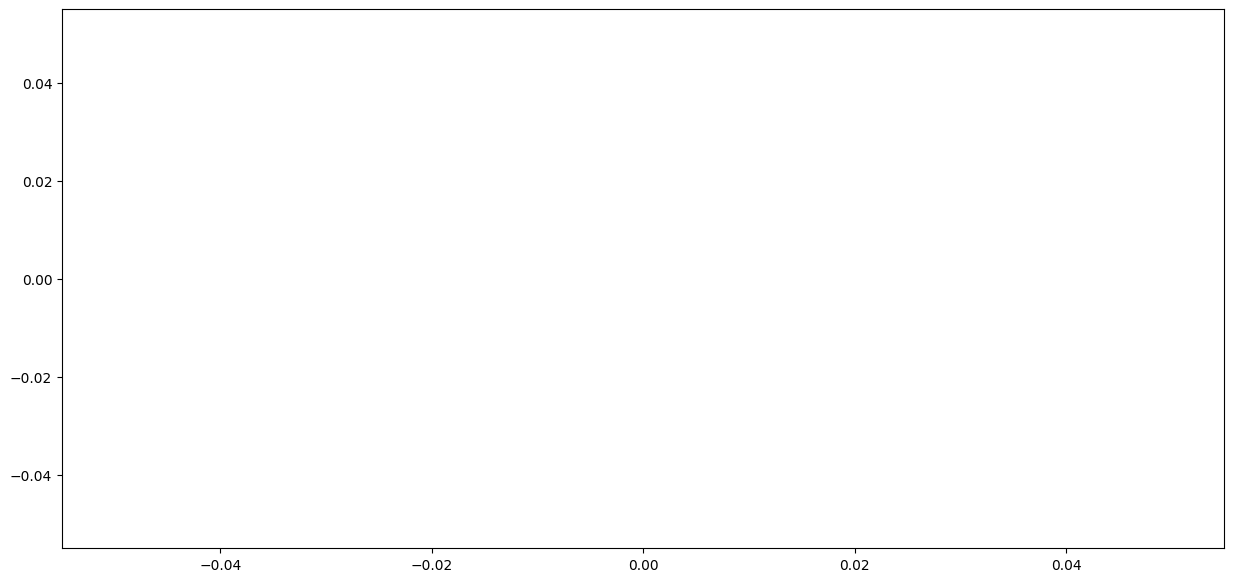

tensor(0., dtype=torch.float64)


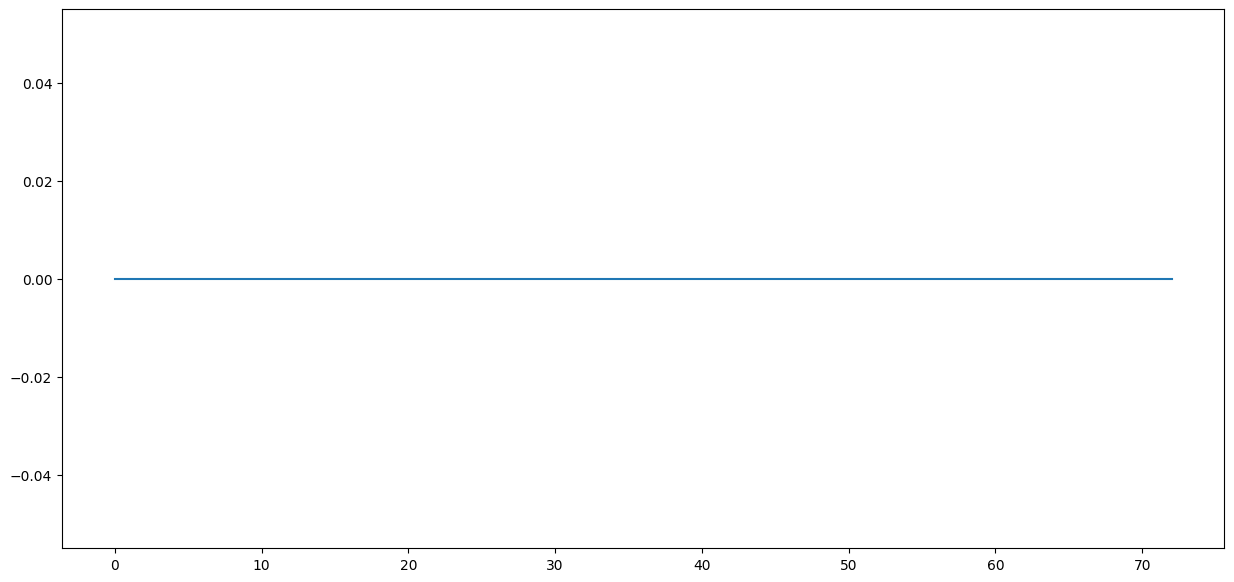

tensor(0., dtype=torch.float64)


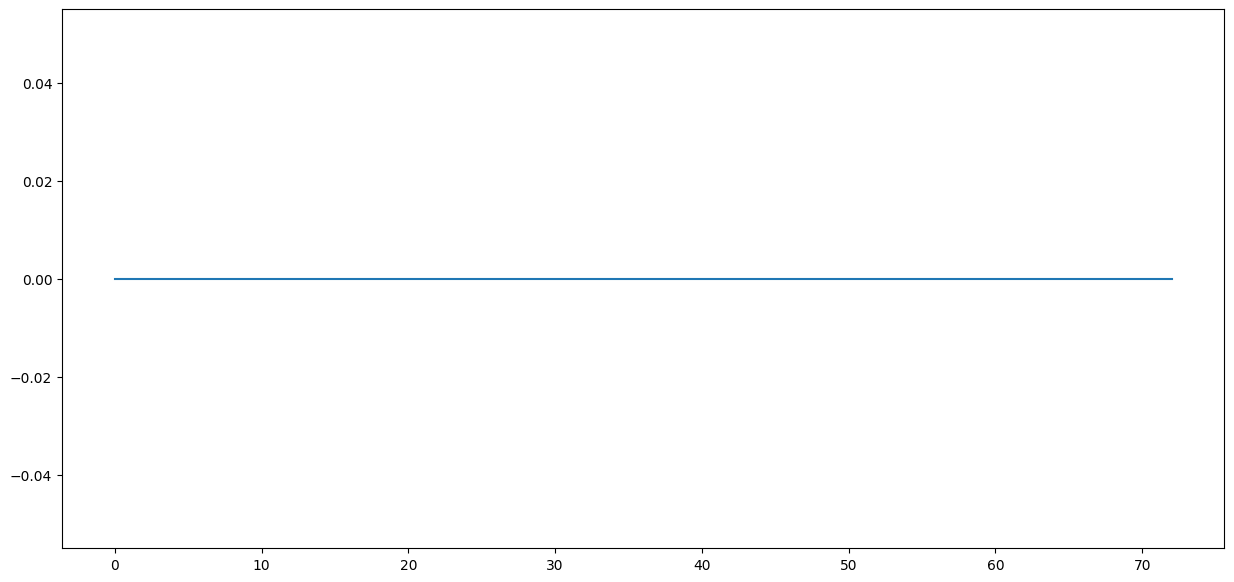

tensor(0., dtype=torch.float64)


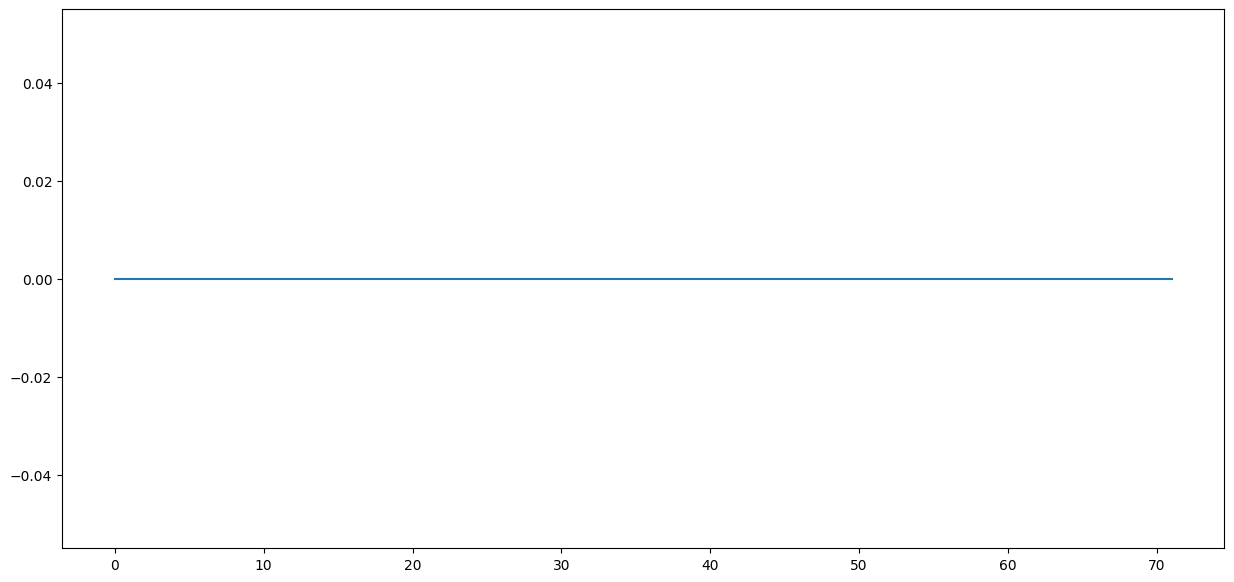

tensor(0., dtype=torch.float64)


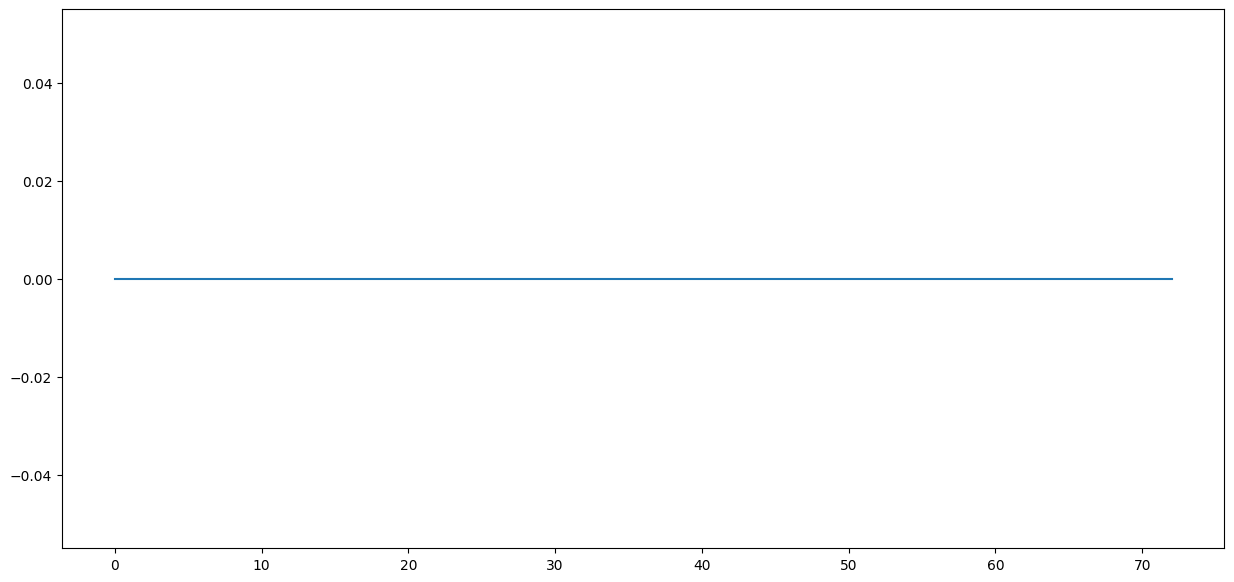

tensor(0., dtype=torch.float64)


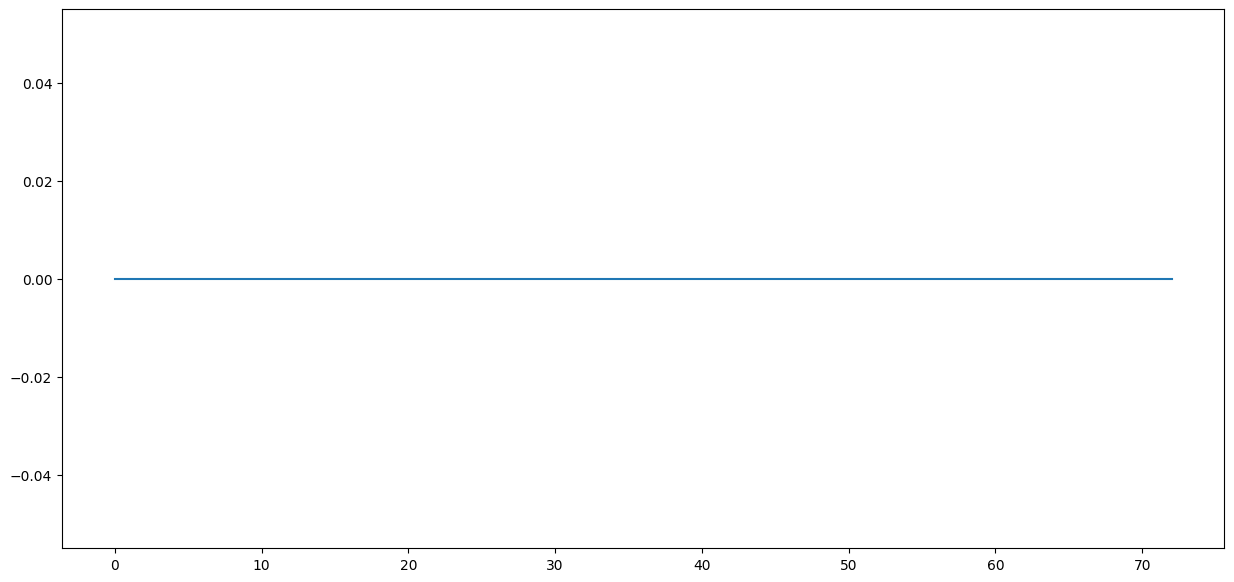

tensor(0., dtype=torch.float64)


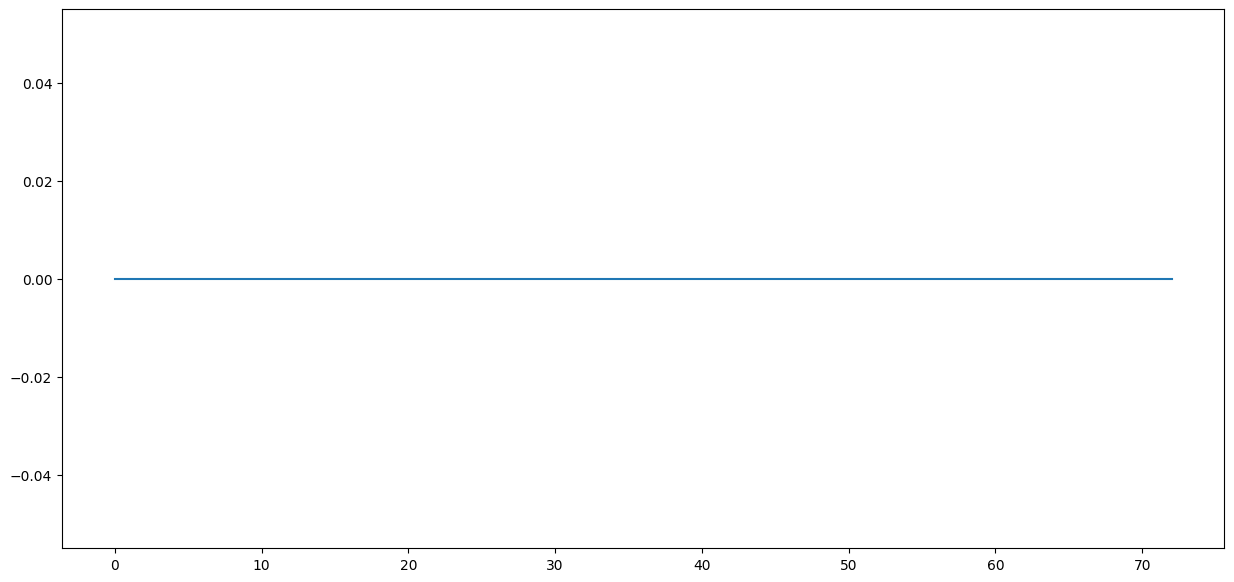

tensor(0., dtype=torch.float64)


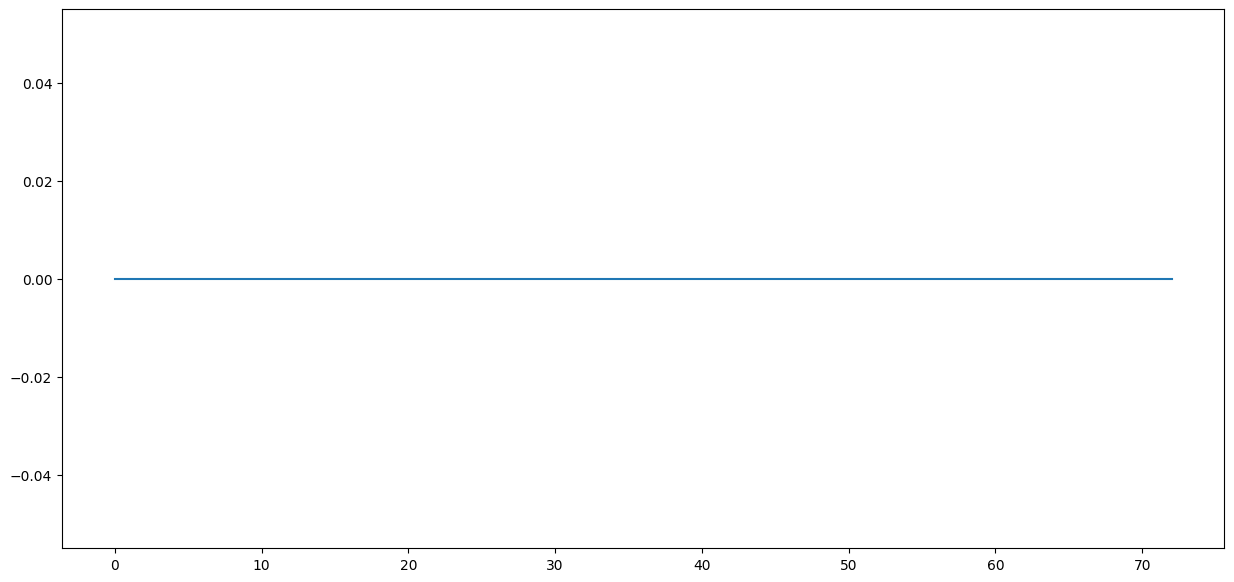

tensor(0., dtype=torch.float64)


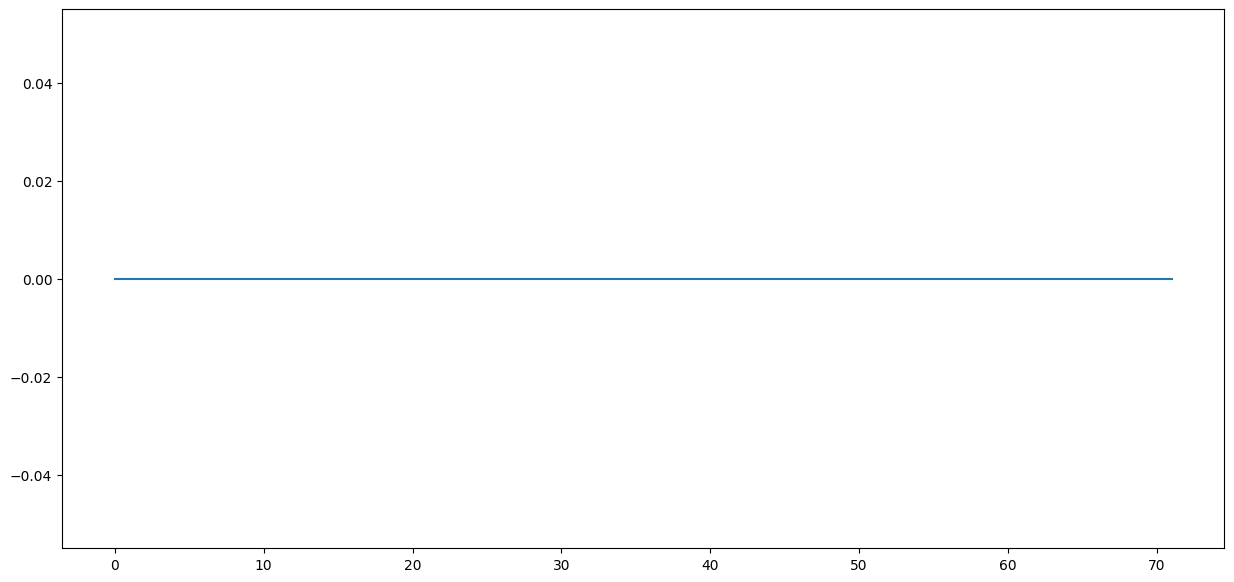

tensor(0., dtype=torch.float64)


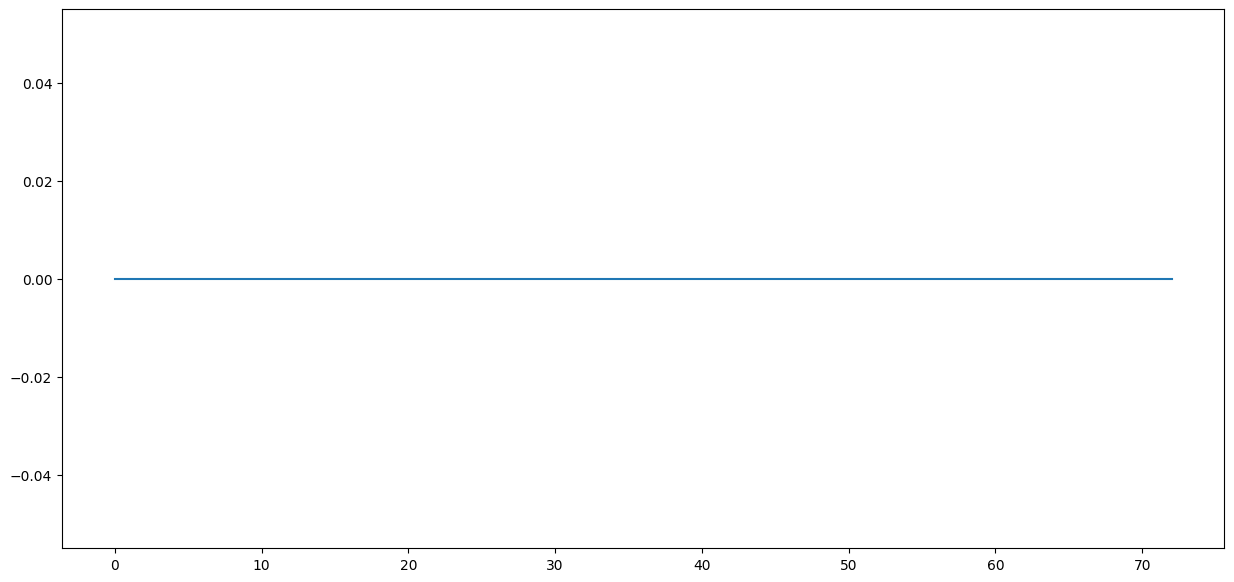

tensor(0., dtype=torch.float64)


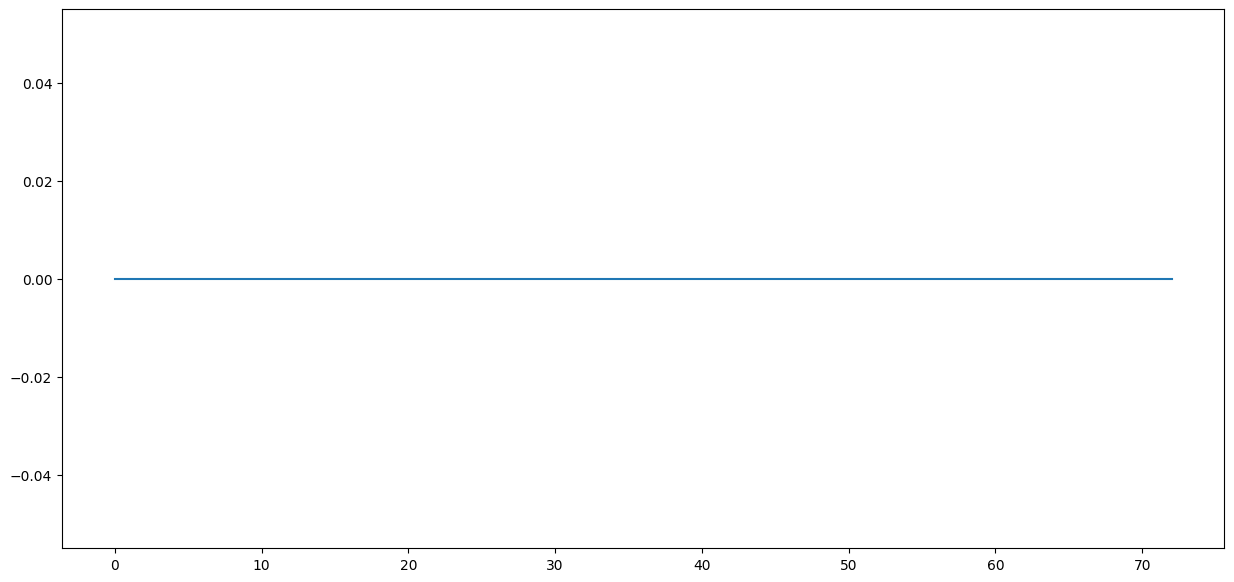

tensor(0., dtype=torch.float64)


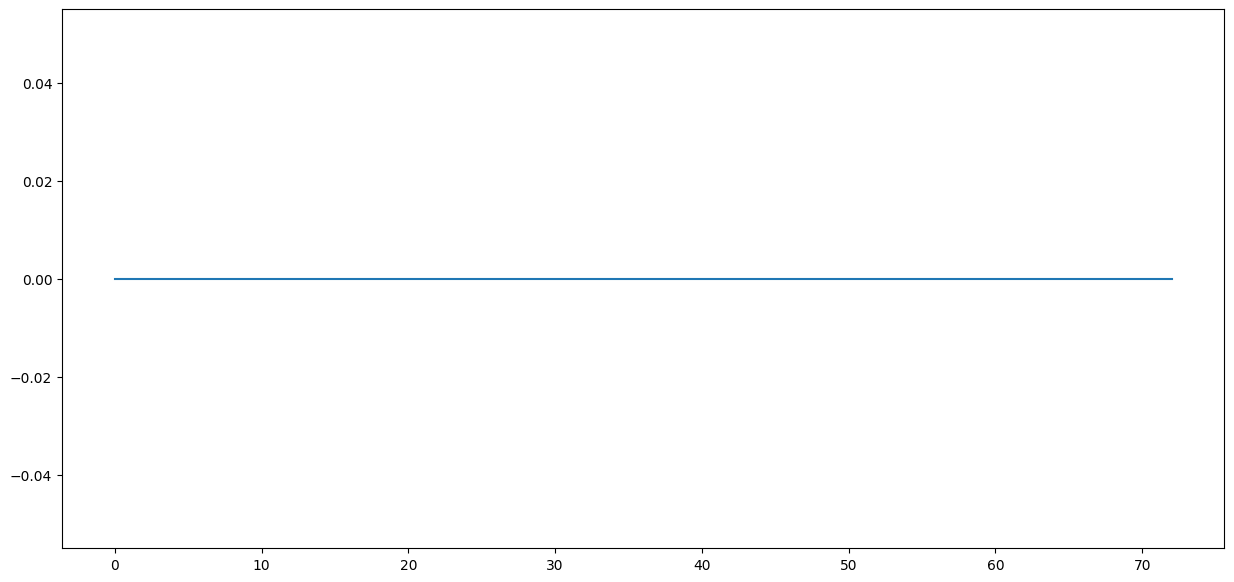

tensor(0., dtype=torch.float64)


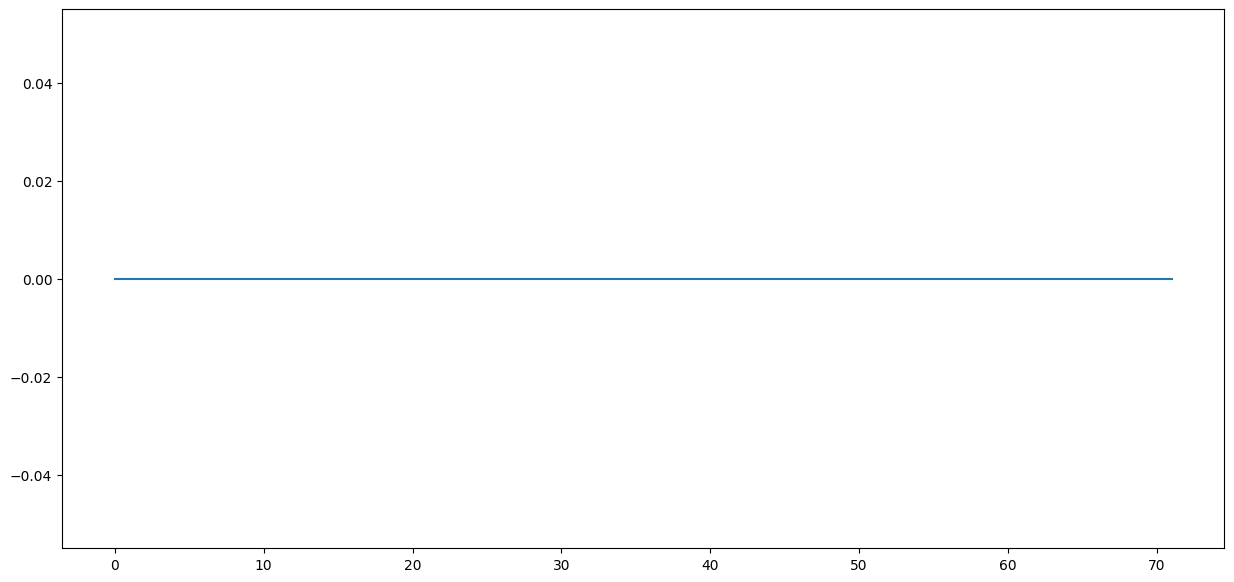

tensor(0., dtype=torch.float64)


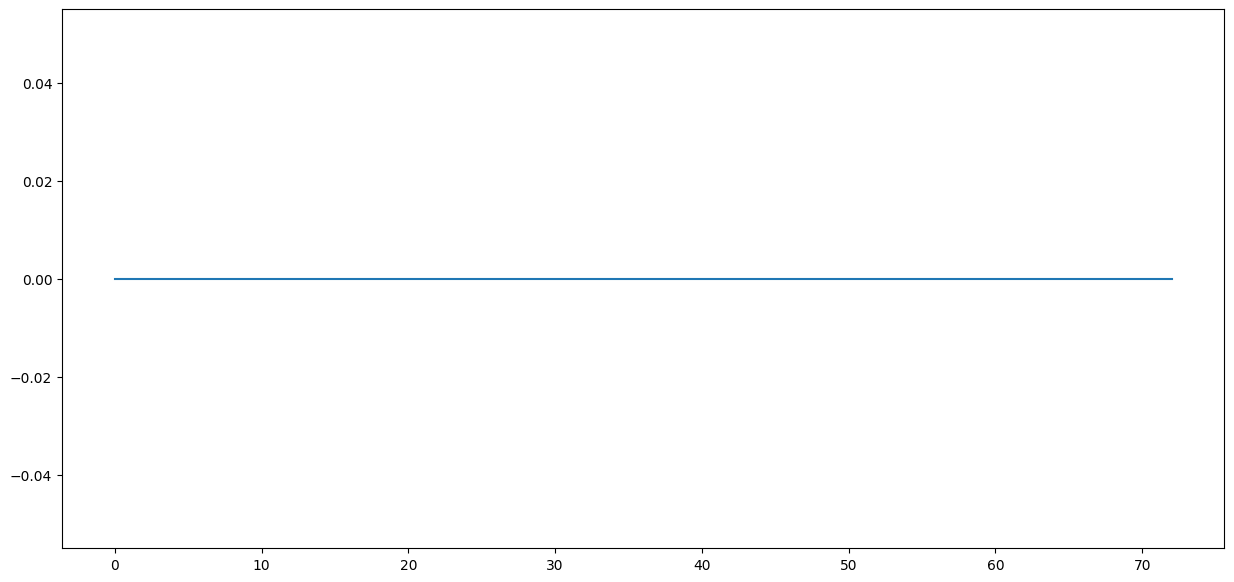

tensor(0., dtype=torch.float64)


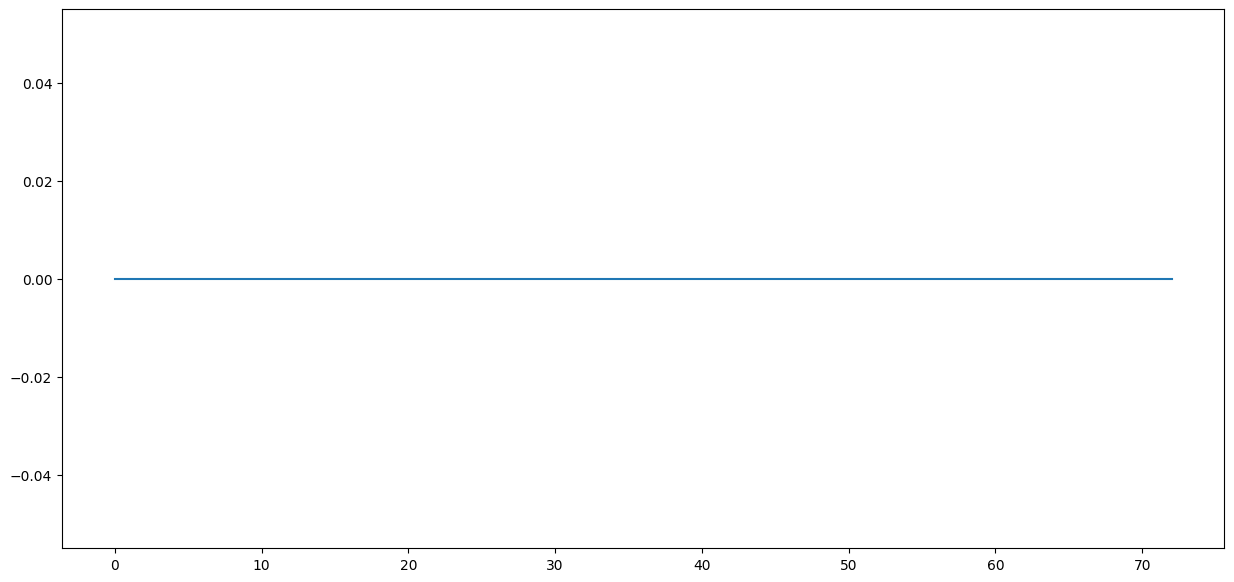

tensor(0., dtype=torch.float64)


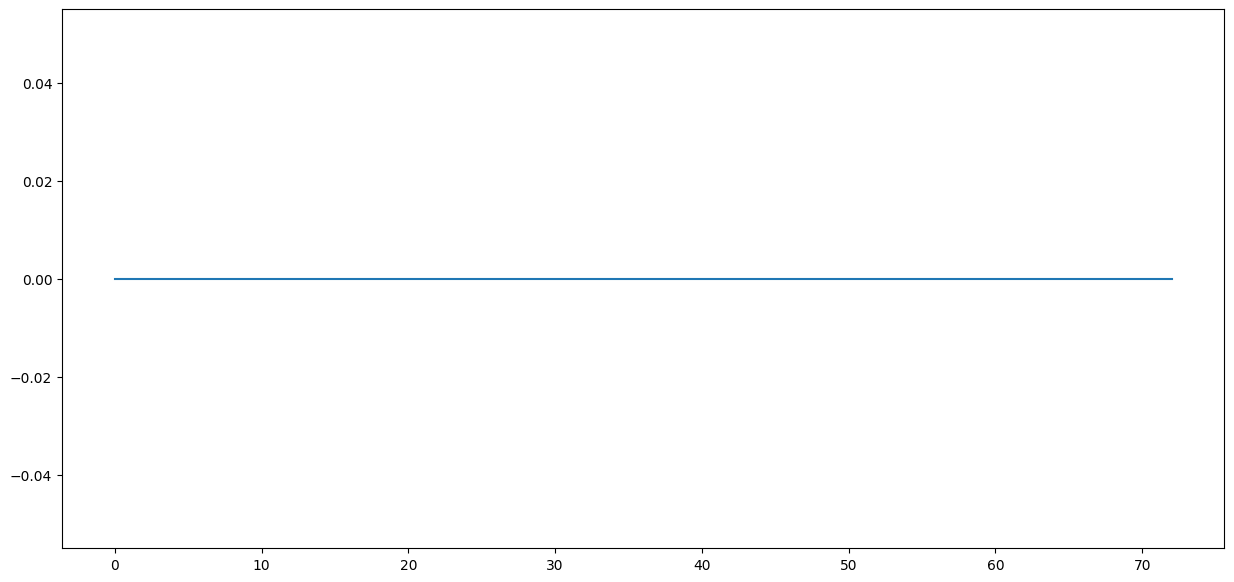

tensor(0., dtype=torch.float64)


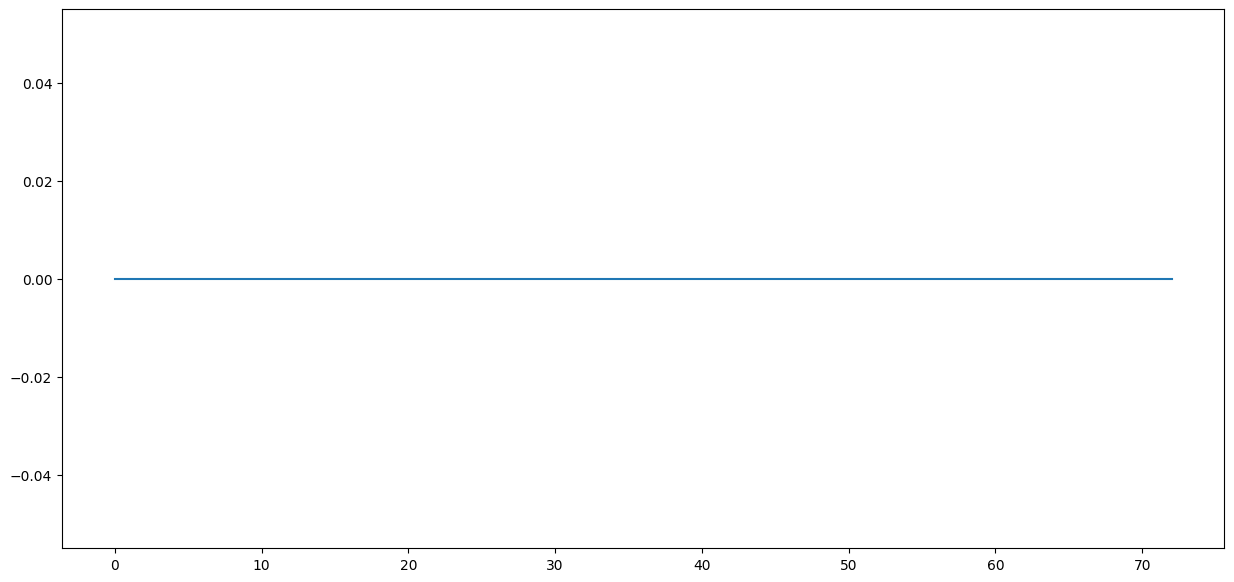

tensor(0., dtype=torch.float64)


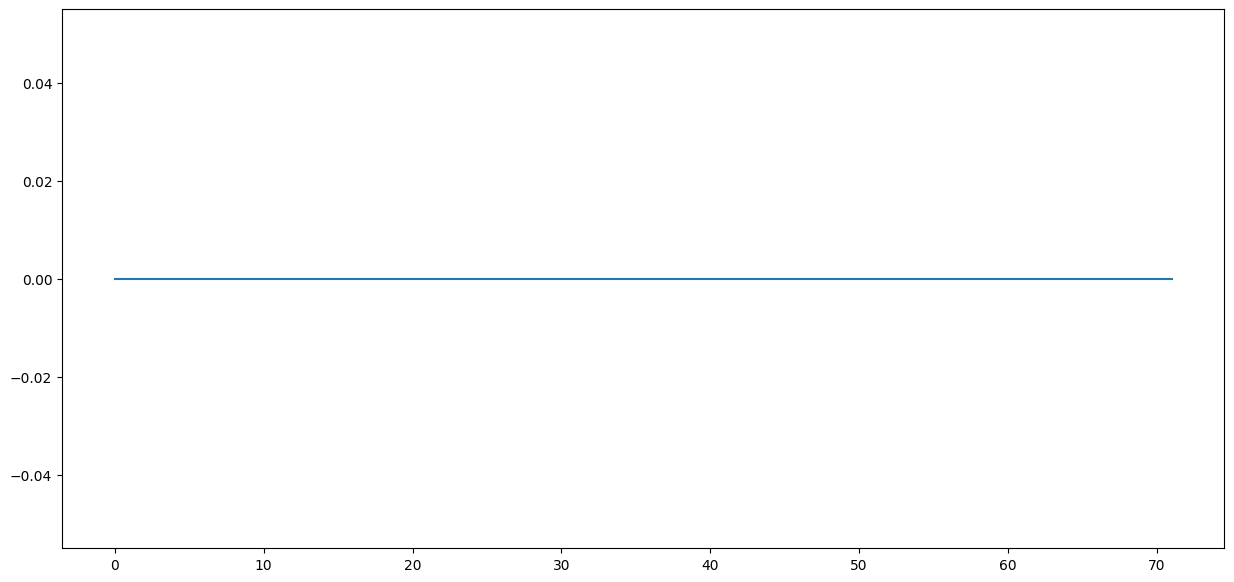

tensor(0., dtype=torch.float64)


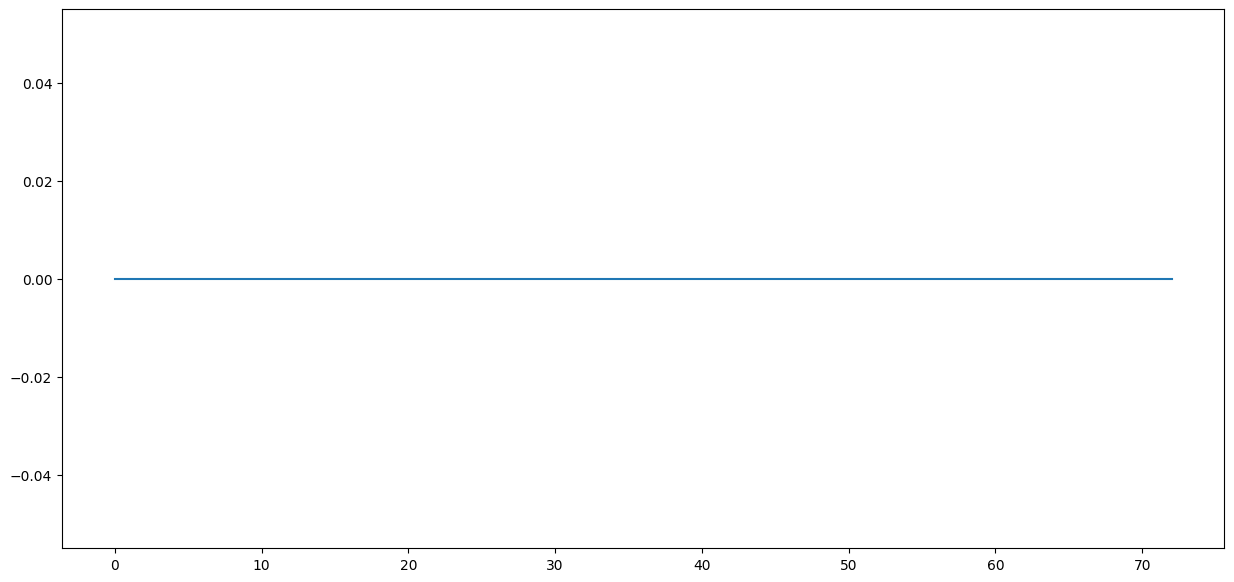

tensor(0., dtype=torch.float64)


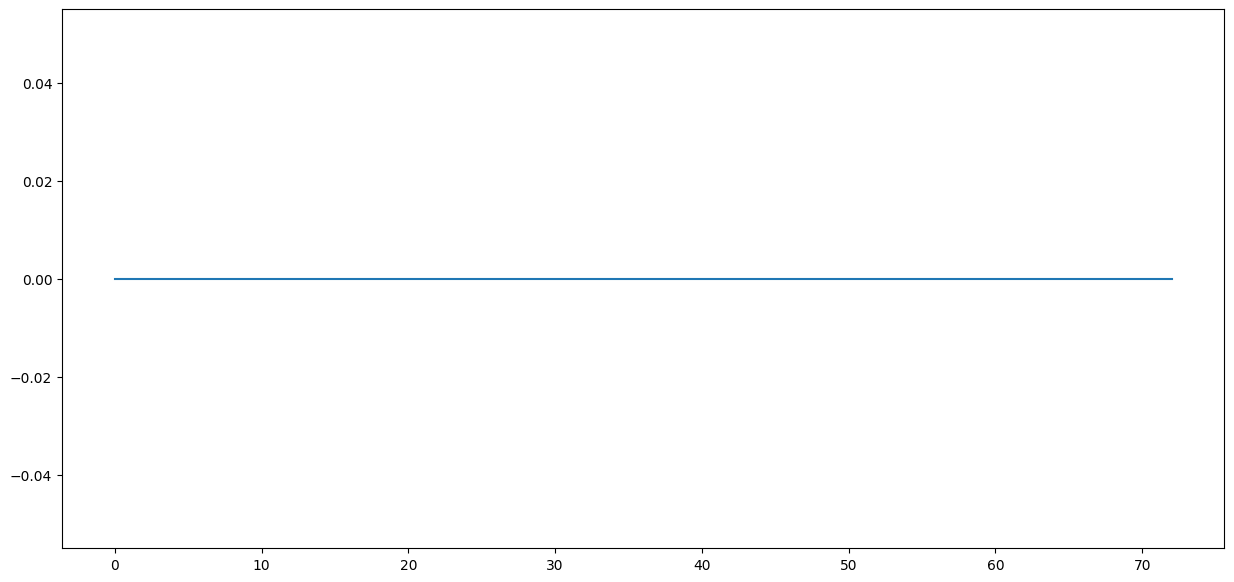

In [62]:
old = 0 
for i in np.round(np.linspace(0, len(flux_rebinned_n),20),0):
    plt.figure(figsize=(15,7))
    i = int(i)
    if i == 0:
        continue
#     plt.plot(flux_rebinned_n[old:i,0], flux_rebinned_n[old:i,1])
#     plt.plot(flux_rebinned_o[old:i,0], flux_rebinned_n[old:i,1])
    plt.plot(flux_rebinned_n[old:i,1]- flux_rebinned_n[old:i,1])
    print((flux_rebinned_n[old:i,1]- flux_rebinned_n[old:i,1]).sum())
    plt.show()
    old = i

In [33]:
(flux_rebinned_n[:,0]- flux_rebinned_o[:,0]).sum()

tensor(0., dtype=torch.float64)

In [64]:
(flux_rebinned_n[:i,1]- flux_rebinned_n[:i,1]).sum()

tensor(0., dtype=torch.float64)

# They are identical !!

In [13]:
'''
The spec (obs/sim) that is being 
rebinned should always be longer than the simulation such that 
- spec[1] <= ref_spec[1] - wl_bins[1]/2
- spec[-1] >= ref_spec[-1] + wl_bins[1]/2
Otherwise, it doesn't work and throw the error - 
STOP rebin.f90 ERROR: extent of fine wavelength grid is too small! - 

'''

"\nThe spec (obs/sim) that is being \nrebinned should always be longer than the simulation such that \n- spec[1] <= ref_spec[1] - wl_bins[1]/2\n- spec[-1] >= ref_spec[-1] + wl_bins[1]/2\nOtherwise, it doesn't work and throw the error - \nSTOP rebin.f90 ERROR: extent of fine wavelength grid is too small! - \n\n"

## Saving rebinned spectrum

In [19]:
len(spec.iloc[:,0]), flux_rebinned_o.size()

(9746, torch.Size([1386, 4]))

In [20]:
flux_rebinned_o

tensor([[4.9098e+00, 3.0084e-04, 9.7575e-06, 0.0000e+00],
        [4.9147e+00, 3.9465e-04, 9.3820e-06, 0.0000e+00],
        [4.9196e+00, 3.0224e-04, 9.7287e-06, 0.0000e+00],
        ...,
        [1.7925e+01, 4.3685e-04, 1.6766e-05, 8.0000e+00],
        [1.7943e+01, 4.4177e-04, 1.6186e-05, 8.0000e+00],
        [1.7961e+01, 5.2796e-04, 1.7206e-05, 8.0000e+00]], dtype=torch.float64)

In [21]:
rebinned_spectrum_pd = pd.DataFrame(flux_rebinned_o.numpy())
col_list = ['wavelength[um]', 'flux[Jy]', 'error[Jy]', 'channels']
rebinned_spectrum_pd.columns = col_list

In [22]:
# rebinned_spectrum_pd.to_csv('rebinned_observation_1296.csv', sep=',', index=False)
rebinned_spectrum_pd.to_csv('unconvolved/rebinned_observation_reprocessed231123.csv', sep=',', index=False)